In [30]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
//   MODEL:
//   y ~ multinormal(xi*beta,sigma2)
//   sigma2 ~ invgamm(a_sigma2,b_sigma2)
//   beta ~ DP(p0,alpha)
//   p0=multinormal p+1(mu0,sigma0)
//   alpha ~ gamma(a_alpha,b_alpha)
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    //To build sigma2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // To build P_zero of dirchlet process
    vector[P+1] mu_0;
    matrix[P+1,P+1] Sigma_0;
    
    //to build alpha of dp
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
}
transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
}
parameters{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    matrix[P+1,H] betas;
    vector<lower=0,upper=1>[H-1] vs;       // to build mixture Dirichlet process
}
transformed parameters
{
    simplex[H] omegas;    // wights of sbc
    
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
}
model
{
    alpha ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    vs ~ beta(1,alpha);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) {
    
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] , sigma2*eye_T);
        
        target += log_sum_exp(log_probs);
    }
}
generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  , sigma2*eye_T);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "SimpleModel_NoRandomEffect.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)



21:55:45 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan to exe file /home/riccardo/bayesian-project/SimpleModel_NoRandomEffect
21:56:13 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/SimpleModel_NoRandomEffect


[[1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]]


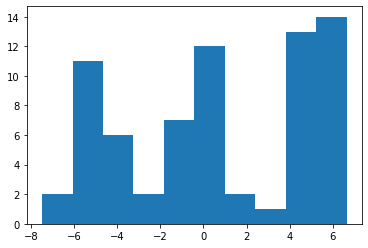

In [33]:
I = 10
T = 7
P = 3
means = np.array([-5, 0, 5]) #vector of possible mean 
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal allocation 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

mu_0 = np.zeros(P+1) #as in the paper

mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix

data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_sigma2": 3,
    "b_sigma2": 2
}

In [34]:
true_clus_allocs

array([2., 2., 0., 1., 0., 2., 1., 1., 2., 0.])

In [42]:
fit = dp_mix.sample(data)

22:04:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:05:05 - cmdstanpy - INFO - CmdStan done processing.
22:05:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan', line 60, column 4 to column 35)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan', line 60, column 4 to column 35)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/riccardo/bayesian-project/SimpleModel_NoRandomEffect.stan', line 60, column 4 to column 35)
Consider re-running with show_console=True if the above output is unclear!


In [43]:
fit = az.from_cmdstanpy(fit)

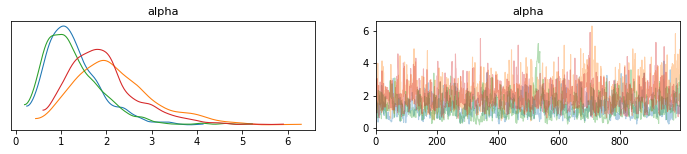

In [44]:
az.plot_trace(fit, var_names=["alpha"], compact=False)
plt.show()

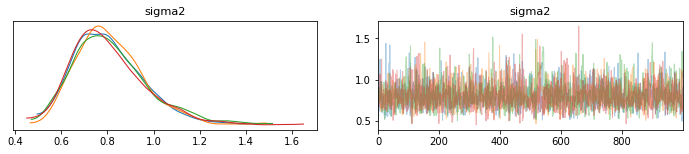

In [45]:
az.plot_trace(fit, var_names=["sigma2"], compact=False)
plt.show()

/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/riccardo/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/riccardo/.local/lib/python3.9/site-package

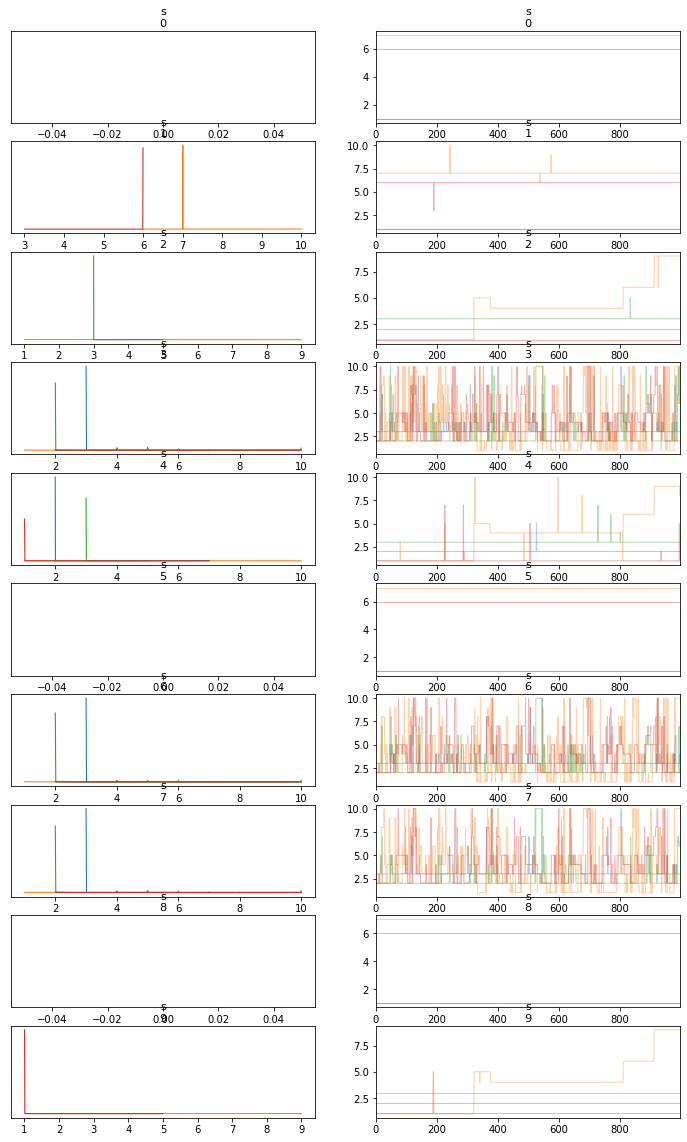

In [46]:
az.plot_trace(fit, var_names=["s"], compact=False)
plt.show()

In [47]:
clus =  np.array(fit.posterior.s.values[0, -1, :])
print('s')
print(clus)
print('true clusters')
print(true_clus_allocs)

s
[1. 1. 2. 3. 2. 1. 3. 3. 1. 2.]
true clusters
[2. 2. 0. 1. 0. 2. 1. 1. 2. 0.]


/home/riccardo/.local/lib/python3.9/site-packages/arviz/plots/traceplot.py:215: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


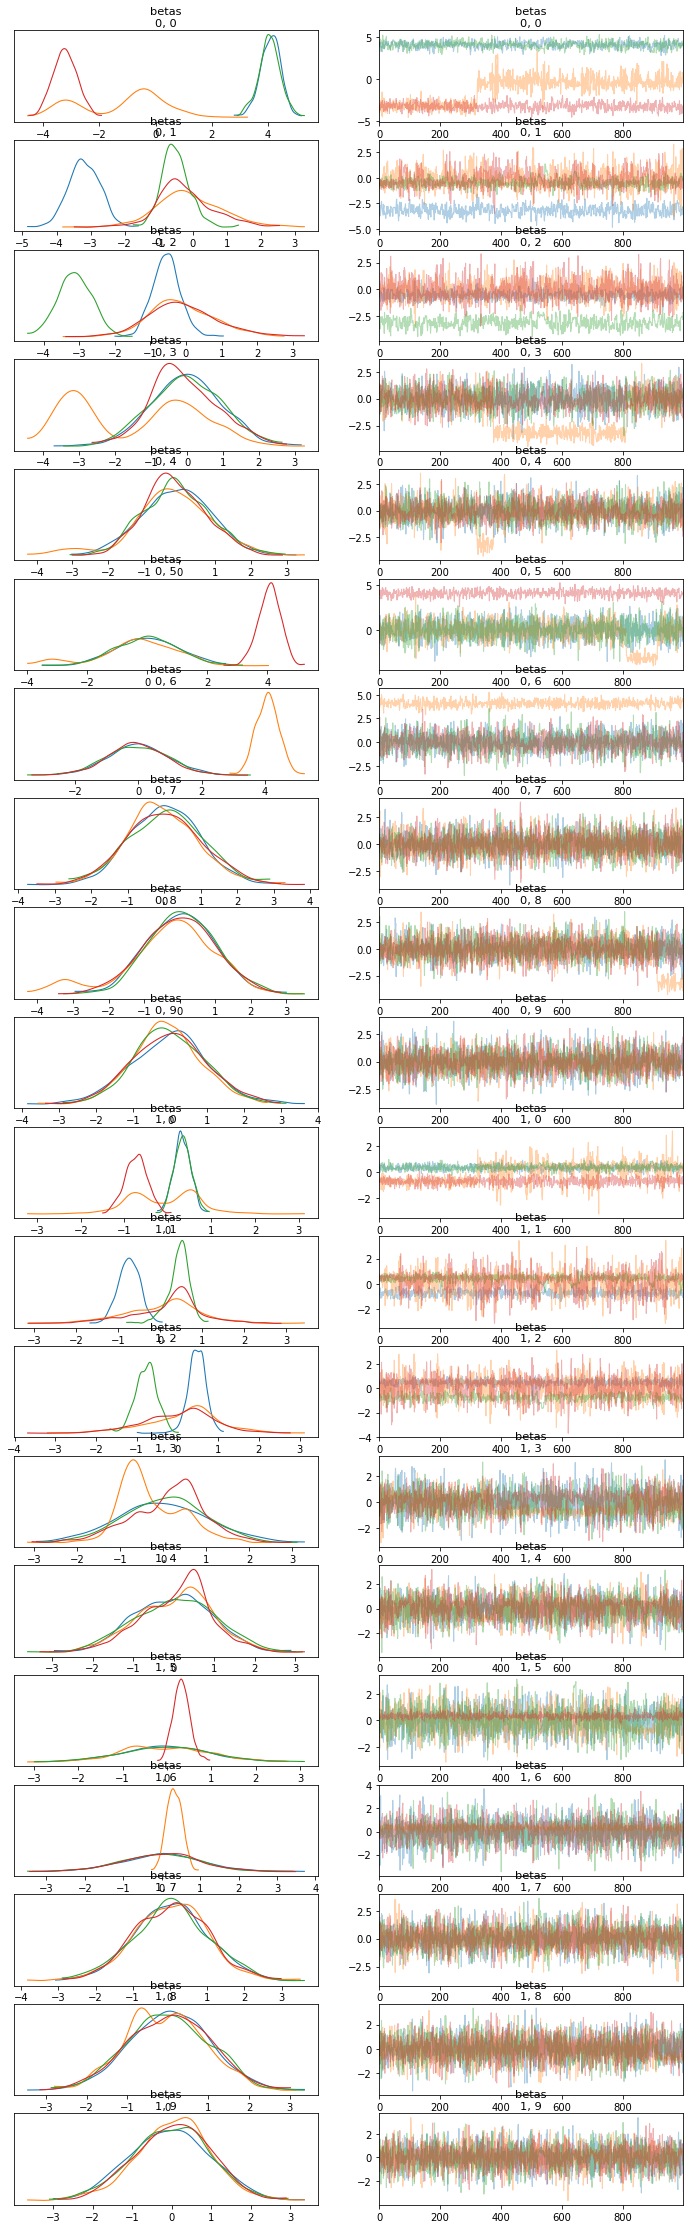

In [49]:
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()